In [1]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
# from unet import AttUNet, UNet, UNetWithPretrainedEncoder
# from dataloader import ImageDataset, TransformWrapper
import os
import random
from random import shuffle
import numpy as np
import torch
from torch.utils import data
from torchvision import transforms as T
import torchvision.transforms.functional as F

from PIL import Image
from PIL.ImageFile import ImageFile

from pathlib import Path

from PIL import Image
import numpy as np
import cv2

def apply_clahe(pil_img):
    # Convert PIL image to NumPy array
    img = np.array(pil_img)

    # If grayscale
    if len(img.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img)
    # If RGB
    elif len(img.shape) == 3:
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)
        img_lab_clahe = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError("Unsupported image format")

    # Convert back to PIL image
    return Image.fromarray(img_clahe)


class TransformWrapper:

    def __init__(self):
        self.image_transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=[30, 60, 90, 120, 150]),
            T.ToTensor(),
        ])

        self.mask_transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=45),
            T.ToTensor(),
        ])

    def __call__(self, image, mask):
        # Apply the same random seed to ensure consistent transformations
        seed = torch.randint(0, 2**32, (1, )).item()
        torch.manual_seed(seed)
        image = self.image_transforms(image)

        torch.manual_seed(seed)
        mask = self.mask_transforms(mask)

        return image, mask


class ImageDataset(data.Dataset):

    def __init__(self,
                 images: list[ImageFile],
                 masks: list[ImageFile],
                 transform: bool = False,
                 image_size: int = 224):

        self.images = images
        self.masks = masks
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,
                    index) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        image = self.images[index]
        mask = self.masks[index]

        image = image.resize((self.image_size, self.image_size),
                             Image.Resampling.LANCZOS)
        mask = mask.resize((self.image_size, self.image_size),
                           Image.Resampling.LANCZOS)

        image = apply_clahe(image)
        image = T.GaussianBlur(3)(image)

        mask = mask.convert("L")  # Ensure mask is in grayscale
        binary_threshold = 100  # Adjust this threshold as needed
        mask = mask.point(lambda p: 255 if p > binary_threshold else 0)
        mask = mask.convert('1')
        

        normalize_tensor = T.Compose([
            T.Lambda(lambda x: x.convert("RGB")),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            T.Lambda(lambda x: x),
        ])

        if self.transform:
            angle = random.uniform(-90, 90)
            
            image = F.rotate(image, angle)
            image = normalize_tensor(image)
            mask = T.ToTensor()(F.rotate(mask, angle))
            return image, mask

        return normalize_tensor(image), T.ToTensor()(mask)

data_pth = Path(
    '/Users/tsakalis/Downloads/ECImageAnalysisMouse/New Binary Masks')
blastocyst_pth = Path('/home/tsakalis/ntua/phd/cellforge/cellforge/data')

full_path = "/Users/tsakalis/ntua/cellforge/data/D2016.07.08_S1366_I149_11"

blastocyst_images_pth = blastocyst_pth / 'annotation_pn/images_pn'
blastocyst_msk_pth = blastocyst_pth / 'annotation_pn/masks_pn'

smooth = 1e-15

device = 'cuda'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [2]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.png')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)


In [3]:
import numpy as np
from PIL import Image
from scipy.ndimage import center_of_mass


def crop_around_center(image: Image.Image, mask: Image.Image,
                       crop_size: int) -> Image.Image:
    """
    Finds the center of mass of the non-zero pixels in the image
    and crops the image around that point.

    Args:
        image (PIL.Image.Image): Input image (grayscale or binary recommended).
        crop_size (int): Size of the square crop (e.g., 128 for 128x128 crop).

    Returns:
        PIL.Image.Image: Cropped image around the center of mass.
    """
    # Convert image to grayscale and NumPy array
    image_array = np.array(image.convert("L"))

    # Find the center of mass of non-zero pixels
    com = center_of_mass(image_array)

    # Round to integers for pixel indexing
    center_y, center_x = map(int, com)

    # Calculate crop box
    half_crop = crop_size // 2
    left = max(center_x - half_crop, 0)
    upper = max(center_y - half_crop, 0)
    right = min(center_x + half_crop, image.width)
    lower = min(center_y + half_crop, image.height)

    # Crop the image
    cropped_image = image.crop((left, upper, right, lower))

    cropped_mask = mask.crop((left, upper, right, lower))
    return cropped_image, cropped_mask


# Example usage


In [4]:
image_file_paths = sorted(list(blastocyst_images_pth.glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list(blastocyst_msk_pth.glob('*.png')),
                         key=lambda x: x.stem)


In [5]:
blastocyst_images_pth


PosixPath('/home/tsakalis/ntua/phd/cellforge/cellforge/data/annotation_pn/images_pn')

In [6]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)

# print("... Loading images ...")
images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]

c = list(zip(images, masks))
import random

random.shuffle(c)

images, masks = zip(*c)

# def remove_alpha(img):
#     if img.mode == 'RGBA':  # If image has an alpha channel
#         background = Image.new('RGB', img.size,
#                                (255, 255, 255))  # Create white background
#         background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
#         return background
#     return img  # Return unchanged if no alpha channel

# # Process images and masks
# images = [remove_alpha(img) for img in tqdm(images)]
# masks = [remove_alpha(msk) for msk in tqdm(masks)]

# cropped_images = []
# cropped_masks = []
# for image, mask in zip(images, masks):

#     cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

#     cropped_images.append(cropped)
#     cropped_masks.append(cropped_mask)

train_dataset = ImageDataset(images=images[:400],
                             masks=masks[:400],
                             transform=True)
val_dataset = ImageDataset(images=images[400:800], masks=masks[400:800])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=64)


100%|██████████| 610/610 [00:00<00:00, 16996.10it/s]


In [7]:
len(train_dataloader)

25

In [8]:
import random
from torchvision import transforms as T
import torchvision.transforms.functional as F

In [9]:
for im, gt in train_dataloader:
    break

In [10]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=
    "resnext101_32x48d",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=
    "instagram",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=
    3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)
model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
n_epochs = 10

In [12]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [13]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

/tmp/ipykernel_1417433/3522360610.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:
        img_batch = img_batch.to(device)
        gt_msk_batch = gt_msk_batch.to(device)

        optimizer.zero_grad()
        with autocast():
            pred_mask = model()

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch.to(device))
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )


  0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_1417433/2306933468.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
0.9592396020889282: 100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


Epoch 1 | TrainLoss: 0.9660129523277283 ValLoss: 0.9641322940587997


nan: 100%|██████████| 25/25 [00:06<00:00,  3.65it/s]              


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img_batch[10,0,:].cpu().numpy())

NameError: name 'img_batch' is not defined

In [13]:
import torch


def compute_iou_and_dice(pred: torch.Tensor,
                         gt: torch.Tensor) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Compute intersection and union
    intersection = torch.sum(pred * gt)
    union = torch.sum(pred) + torch.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (torch.sum(pred) + torch.sum(gt))).item() if (
        torch.sum(pred) + torch.sum(gt)) > 0 else 0.0

    return iou, dice


# # Example usage
# pred_mask = torch.randint(0, 2, (256, 256),
#                           dtype=torch.float32)  # Example predicted mask
# gt_mask = torch.randint(0, 2, (256, 256),
#                         dtype=torch.float32)  # Example ground truth mask

iou_fn, dice_fn = compute_iou_and_dice(torch.sigmoid(pred_mask),
                                       gt_msk_batch.to(device))
print(f"IoU: {iou_fn:.4f}, Dice: {dice_fn:.4f}")


IoU: 0.8643, Dice: 0.9272


In [14]:
torch.save(model.state_dict(), "/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/big_good_pn_model.pt")


In [8]:
model.load_state_dict(torch.load("/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/good_pn_model.pt", weights_only=True))
model.eval()


NameError: name 'model' is not defined

In [18]:
model.eval()
gt_masks_all = []
pred_masks_all = []

all_images = []


for img_batch, gt_msk_batch in val_dataloader:

    with torch.no_grad():
        pred_mask = model(img_batch.to(device))
    all_images.append(img_batch)
    pred_masks_all.append(pred_mask.to('cpu'))
    gt_masks_all.append(gt_msk_batch.to('cpu'))


In [19]:
from torchmetrics import JaccardIndex, Dice


In [20]:
iou_fn = JaccardIndex(task='binary', threshold=0.90)
dice_fn = Dice(threshold=0.90)

iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all))

dice_fn(
    torch.sigmoid(torch.vstack(pred_masks_all)),
    torch.vstack(gt_masks_all).long(),
)

print(
    f"IoU: {iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all)):.3f}"
)

print(
    f"Dice Coeff: {dice_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all).long()):.3f}"
)

sample_pred_mask = torch.sigmoid(pred_masks_all[0][3][0].detach())

sample_gt_mask = gt_masks_all[0][3][0].detach()

IoU: 0.837
Dice Coeff: 0.911


In [31]:
sample_path = Path(
    "/home/tsakalis/ntua/phd/cellforge/cellforge/data/D2016.10.18_S1418_I149_6")

image_file_paths = sorted(list(sample_path.glob('*.jpg')),
                          key=lambda x: int(x.stem))

images = [Image.open(img_path) for img_path in tqdm(image_file_paths)][:170]

# def remove_alpha(img):
#     if img.mode == 'RGBA':  # If image has an alpha channel
#         background = Image.new('RGB', img.size,
#                                (255, 255, 255))  # Create white background
#         background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
#         return background
#     return img  # Return unchanged if no alpha channel

# # Process images and masks
# images = [remove_alpha(img) for img in tqdm(images)]
# masks = [remove_alpha(msk) for msk in tqdm(masks)]

# cropped_images = []
# cropped_masks = []
# for image, mask in zip(images, masks):

#     cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

#     cropped_images.append(cropped)
#     cropped_masks.append(cropped_mask)

val_dataset = ImageDataset(images=images, masks=images)

val_dataloader = DataLoader(val_dataset, batch_size=256)

100%|██████████| 560/560 [00:00<00:00, 43937.49it/s]


In [32]:
with torch.no_grad():
    torch.cuda.empty_cache()

import gc
gc.collect()

527182

In [33]:

for inpt_images, _ in val_dataloader: ...

In [34]:
model.eval()

with torch.no_grad():
    pred_mask = model(inpt_images.to(device))

In [35]:
torch.cuda.empty_cache()

In [36]:
masks = (torch.sigmoid(pred_mask)>0.9).cpu().numpy()

In [37]:
cd

/home/tsakalis


/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [38]:
from PIL import Image
import numpy as np
from skimage.morphology import binary_dilation

overlay_color = (255, 0, 0, 128)  # red with 50% transparency
composited_images = []

pn_size = []
final_images = []
upscaled_masks = []
isolated_pns = []
for pil_img, mask in zip(images[:], masks[:]):
    # Ensure the mask is 2D by removing extra dimensions
    # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
    image_ar = np.stack(3*[np.array(pil_img)])
    
    upscaled_mask = cv2.resize(mask[0].astype(np.uint8), (500,500), interpolation=cv2.INTER_NEAREST)
    pn_size.append(upscaled_mask.sum())

    upscaled_masks.append(upscaled_mask)
    image_pn_isolated = image_ar.copy()
    image_pn_isolated[:,~binary_dilation(upscaled_mask).astype(bool)] = 0
    isolated_pns.append(image_pn_isolated.transpose(1,2,0))
    image_ar[0,upscaled_mask.astype(bool)] = 120


    final_images.append(Image.fromarray(image_ar.transpose(1,2,0)))

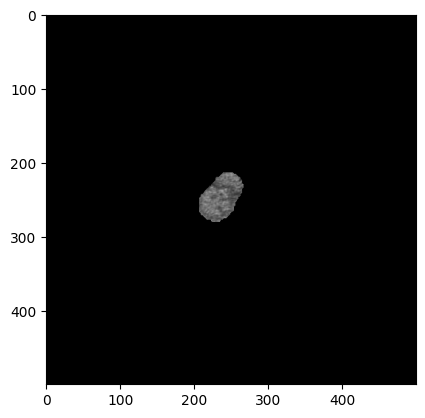

In [39]:
plt.imshow(isolated_pns[44],cmap='gray')
plt.show()

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Assume final_images is already populated with (224, 224, 3) numpy arrays ---

# Frame size of input frames
frame_height, frame_width = 500, 500

# Create a dummy figure to measure the graph size
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1])
fig.canvas.draw()
graph_h, graph_w = fig.canvas.get_width_height()
plt.close(fig)

# Resize the graph to match the height of the frame
scale = frame_height / graph_h
graph_resized_width = int(graph_w * scale)

# Final output size (frame + graph side by side)
output_size = (frame_width + graph_resized_width, frame_height)

# Setup output writer
output = cv2.VideoWriter(
    "accumulated_pn_area_sample4_big.mp4",
    cv2.VideoWriter_fourcc(*'XVID'),
    5,  # FPS
    output_size
)

# Dummy video input just for structure (optional)
cap = cv2.VideoCapture("input.mp4")

pn_size = []
# Process frames
for frame_idx, frame in enumerate(final_images):
    # Generate plot data (example: sine wave)
    x = np.linspace(0, 4 * np.pi, 200)
    y = np.sin(x + frame_idx * 0.1)
    pn_size.append(masks[frame_idx][0].sum())
    x = np.arange(start=0, stop = frame_idx+1, step=1)
    
    # Create and render plot
    fig, ax = plt.subplots()
    ax.plot(x,pn_size)
    
    # ax.set_ylim(-1.5, 1.5)
    ax.set_title(f"Accumulated Pronuclei Size (Frame {frame_idx})")
    ax.set_xlabel('Frame')
    ax.set_ylabel('Accumulated Area')
    fig.tight_layout()
    fig.canvas.draw()

    # Extract RGB image from canvas (modern method)
    plot_img = np.asarray(fig.canvas.buffer_rgba())[:, :, :3]  # Drop alpha
    plt.close(fig)

    # Resize plot to match video height
    plot_resized = cv2.resize(plot_img, (graph_resized_width, frame_height))
    plot_bgr = cv2.cvtColor(plot_resized, cv2.COLOR_RGB2BGR)

    # Combine original frame and graph
    combined = np.hstack((np.array(frame), plot_bgr))

    # Write and display
    output.write(combined)
    cv2.imshow("output", combined)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cv2.destroyAllWindows()
output.release()
cap.release()


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [181]:
def dice_coef_np(y_pred, y_true):

    intersection = np.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        np.sum(y_true).flatten() + np.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [182]:
def compute_iou_and_dice_np(pred, gt) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).astype(float)
    gt = (gt > 0.5).astype(float)

    # Compute intersection and union
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (np.sum(pred) + np.sum(gt))).item() if (
        np.sum(pred) + np.sum(gt)) > 0 else 0.0

    return iou, dice

In [183]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load mask
c = masks[44][0].astype(np.uint8)
_, binary = _, mask

H, W = binary.shape

# Helper to draw a single circle mask
def draw_circle(h, w, x, y, r):
    Y, X = np.ogrid[:h, :w]
    return ((X - x)**2 + (Y - y)**2) <= r**2

# Loss function: overlap mismatch between union of circles and the binary mask
def loss_fn(params):
    x1, y1, r1, x2, y2, r2 = params
    circle1 = draw_circle(H, W, x1, y1, r1)
    circle2 = draw_circle(H, W, x2, y2, r2)
    union = np.logical_or(circle1, circle2).astype(np.uint8)
    iou, dice = compute_iou_and_dice_np(union,binary)
    return -iou#dice_coef_np(union, binary)
    

# Initial guess: center of image and equal radii
initial_guess = [W//3, H//2, 100, 2*W//3, H//2, 1]

# Bounds to constrain solution
bounds = [
    (0, W), (0, H), (5, W//2),
    (0, W), (0, H), (5, W//2),
]

# Run optimization
result = minimize(loss_fn, initial_guess, bounds=bounds, method='L-BFGS-B')
x1, y1, r1, x2, y2, r2 = result.x

circle1 = draw_circle(H, W, x1, y1, r1)
circle2 = draw_circle(H, W, x2, y2, r2)
union = np.logical_or(circle1, circle2).astype(np.uint8)
# Visualize
result_mask = np.zeros((H, W), dtype=np.uint8)
cv2.circle(result_mask, (int(x1), int(y1)), int(r1), 1, -1)
cv2.circle(result_mask, (int(x2), int(y2)), int(r2), 1, -1)
result_mask *= 255

overlay = cv2.merge([binary * 255, result_mask, np.zeros_like(result_mask)])

plt.imshow(overlay)
plt.title("Green: Fitted Circles | Red: Original Mask")
plt.axis("off")
plt.show()


ValueError: too many values to unpack (expected 2)

In [184]:
from skimage.color import rgb2gray



In [185]:
rgb2gray(isolated_pns[44])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
label_im

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


image = upscaled_masks[44]

label_img = label(image)
regions = regionprops(label_img)

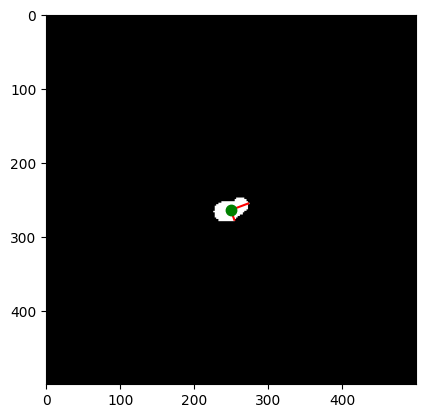

In [203]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    # ax.plot(bx, by, '-b', linewidth=2.5)


plt.show()

In [205]:
props = regionprops_table(
    label_img,
    properties=None

)

TypeError: 'NoneType' object is not iterable

In [201]:
props


{'centroid-0': array([263.81139122]),
 'centroid-1': array([249.22875817]),
 'orientation': array([-1.21167299]),
 'axis_major_length': array([50.30582695]),
 'axis_minor_length': array([27.92539493])}

In [35]:
import sys
import matplotlib
matplotlib.use('TkAgg')

In [84]:
sample_pred_mask = mask[0]
sample_gt_image = image_ar[0]

In [38]:
import matplotlib.pyplot as plt

# Assuming 'source_image', 'sample_gt_mask', and 'sample_pred_mask' are numpy arrays
# Display side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original ground truth mask
axes[0].imshow(sample_gt_mask.numpy(), cmap='gray')
axes[0].set_title("Ground Truth Mask")
axes[0].axis('off')

# Prediction mask thresholded
axes[1].imshow(mask[0] > 0.4, cmap='gray')
axes[1].set_title("Predicted Mask > 0.4")
axes[1].axis('off')

# Overlay source image with ground truth and predicted masks
overlay_image = all_images[0][3][0].numpy().copy()
# Adjust overlay to include masks for better visibility

axes[2].imshow(overlay_image, cmap='gray')
axes[2].set_title("Overlay with Source Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()


TypeError: Invalid shape (224,) for image data